# Feature Selection

Один из важных этапов обучения модели - отбор признаков. Иногда их может оказаться много - гораздо больше, чем нужно для эффективной работы моделей. На прошлых занятиях мы уже познакомились с методом главных компонент, PCA, и говорили о проклятии размерности.

Мы знаем многое о том, как отбирать признаки. В этой тетрадке структурируем наши знания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


## 0. Data

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
11258,19546.0,-0.454749,-4.054983,-0.273254,-0.399568,-2.590132,-0.393092,0.138466,-0.391686,-0.873562,...,0.054097,-1.563757,-0.628145,0.457243,-0.338810,-0.653193,-0.184372,0.185015,1002.00,0
78321,57475.0,-6.423197,1.072629,-3.820238,-0.269845,-4.125205,-0.690805,-0.196968,2.840871,-0.307457,...,0.011082,0.109586,-0.041425,0.576822,-0.291755,0.837947,-0.077805,-0.788987,255.30,0
226814,144808.0,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,-2.322716,...,0.652683,0.414132,0.023869,-0.260616,0.405316,0.029107,0.519807,-0.469537,667.55,1
276476,167121.0,-0.454736,0.189683,0.839674,-0.810172,0.458127,0.106038,0.427228,0.195571,-1.232442,...,-0.136466,0.090678,-0.255906,0.628284,0.175469,-0.617653,0.147898,0.142017,9.94,0
174521,121948.0,0.014204,0.516012,0.248349,-0.307436,0.180279,1.025058,-0.806851,-1.255250,0.843365,...,1.673448,0.206028,-0.294641,0.199466,0.902569,0.829324,0.220143,0.262698,7.50,0


**Задание** Давайте проверим, сколько "фрода" в этой выборке?

In [213]:
sum(data.Class) / data.shape[0]

0.017010095422486517

In [67]:
data.shape

(28924, 31)

## 1. Поиск константных признаков

$$ R_j = \frac{1}{l}\sum \limits _{i=1}^{l}{(x_{ij} - \bar{x_j})^2}$$
- Чем больше $R_j$, тем информативнее признак
- Никак не учитываются ответы
- Подходит для фильтрации константных и близких к ним признаков

**Задание** Посчитайте дисперсию признаков

In [216]:
data.var().sort_values()

Class     1.672133e-02
V28       1.195153e-01
V27       1.884534e-01
V26       2.315999e-01
V25       2.710506e-01
V23       3.195089e-01
V24       3.663248e-01
V22       5.507245e-01
V20       5.595187e-01
V19       6.871294e-01
V21       7.431351e-01
V15       8.322096e-01
V18       8.920157e-01
V13       9.975366e-01
V16       1.241883e+00
V11       1.350963e+00
V9        1.369498e+00
V6        1.819494e+00
V12       1.903163e+00
V14       1.911382e+00
V10       2.005135e+00
V8        2.049696e+00
V17       2.123134e+00
V4        2.392735e+00
V5        2.423572e+00
V7        2.719237e+00
V2        2.882808e+00
V3        3.747619e+00
V1        4.722414e+00
Amount    5.545650e+04
Time      2.258724e+09
dtype: float64

In [215]:
data.nunique()

Time      28793
V1        28690
V2        28690
V3        28690
V4        28690
V5        28690
V6        28690
V7        28690
V8        28690
V9        28690
V10       28690
V11       28690
V12       28690
V13       28690
V14       28690
V15       28690
V16       28690
V17       28690
V18       28690
V19       28690
V20       28690
V21       28690
V22       28690
V23       28690
V24       28690
V25       28690
V26       28690
V27       28690
V28       28690
Amount     8890
Class         2
dtype: int64

## 2. Поиск коррелирующих признаков


$$ R_j = \frac{\sum \limits _{i=1}^{l}{(x_{ij} - \bar{x_j})(y_i - \bar{y})}}{\sqrt{\sum \limits _{i=1}^{l}{(x_{ij} - \bar{x_j})^2} \sum \limits _{i=1}^{l}{(y_i - \bar{y})^2} }}$$
- Чем больше $|R_j|$, тем информативнее признак
- Учитывает только линейную связь

**Задание**: составьте матрицу корреляций и визуализируйте ее. 
Проанализируйте, есть ли необходимость в удалении каких-либо признаков

<AxesSubplot:>

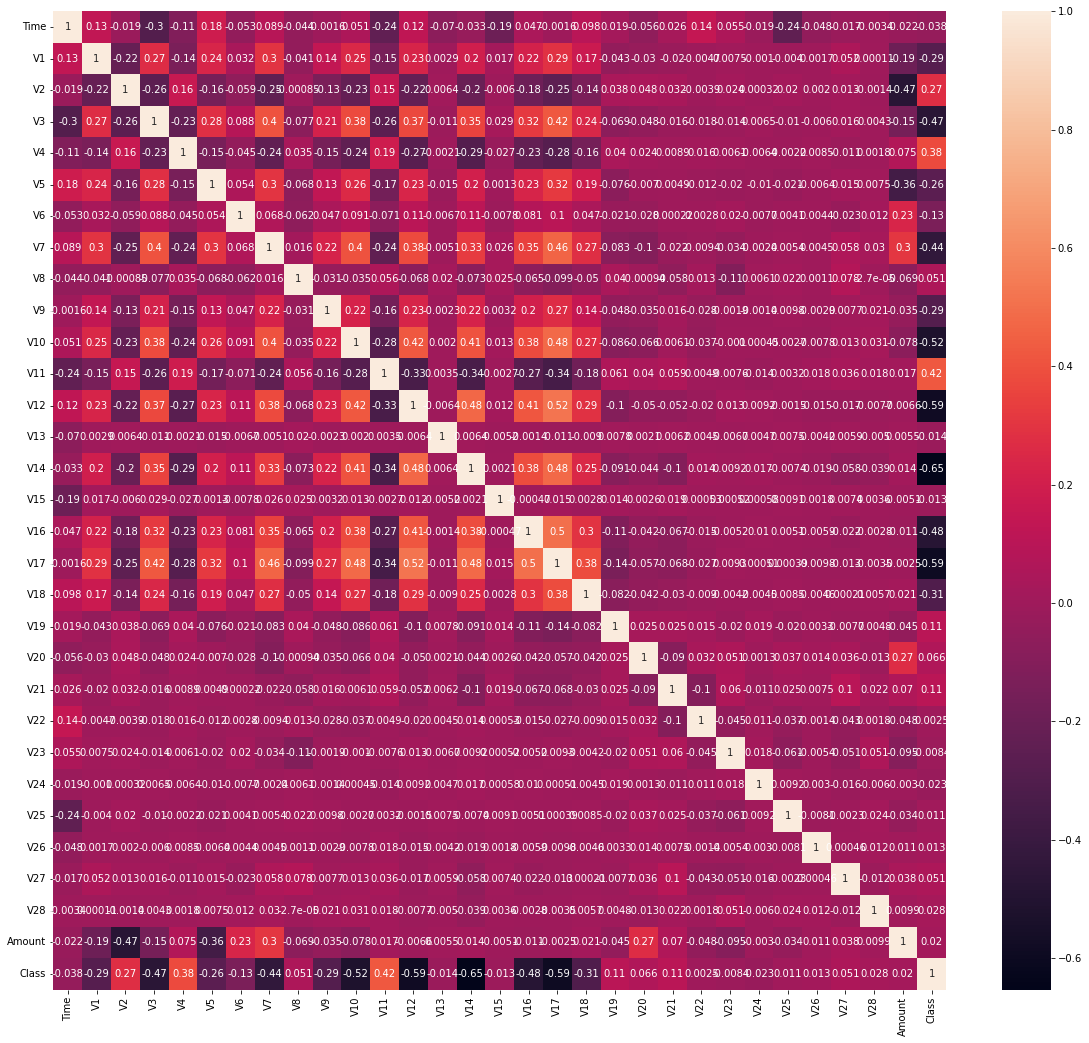

In [78]:
plt.figure(figsize=(20,18))
sns.heatmap(data.corr(),annot=True)

In [239]:
features_corr = ['V14', 'V11', 'V9']

## 3. Оценка T-score

$$ R_j = \frac{|\mu_1 - \mu_2|} {\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2} }} $$

- Для задач бинарной классификации
- Чем больше $𝑅_𝑗$, тем информативнее признак
- $\mu_1, \mu_2$ — средние значения признаков в первом и втором классах
- $\sigma_1^2, \sigma_2^2$ - дисперсии
- $n_1, n_2$ - число объектов в первом и втором классах

**Задание**: напишите функцию, рассчитывающую T-score

In [84]:
def get_t_score(column, target):
    mask = target == 1
    dif = np.abs(column[mask].mean() - column[~mask].mean())
    sq = np.sqrt(column[mask].var()/len(column[mask]) + column[~mask].var()/len(column[~mask])) 
    
    return dif/sq

**Задание**: Рассчитайте t_scores для всех признаков

In [101]:
t_scores = []
for feat in data.columns[:-1]:
    t_scores.append(get_t_score(data[feat], data.Class))
    
t_scores = pd.DataFrame(t_scores,index=data.columns[:-1]).sort_values(0, ascending=False)
t_scores

,0
V14,36.211351
V4,34.940966
V11,31.434558
V12,29.903904
V10,25.764833
V16,23.785926
V9,22.890843
V3,21.939941
V17,21.252745
V2,18.634706


**Задание**: Визуализируйте важность признаков в виде столбцовой диаграммы

<AxesSubplot:>

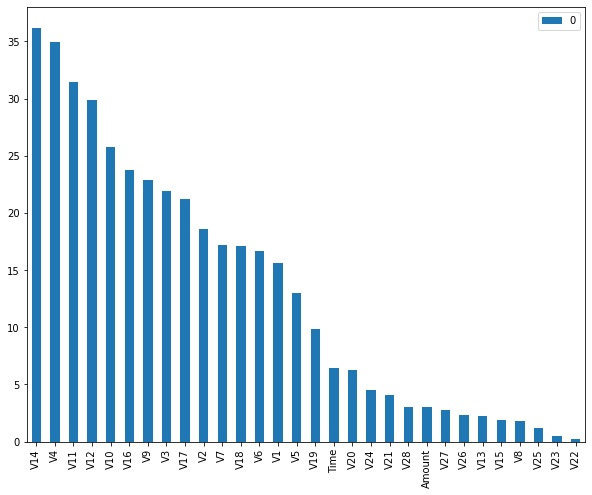

In [137]:
t_scores.plot.bar(figsize=(10,8))

**Задание**: составьте список отфильтрованных признаков. Соберите в небольшую функцию eliminate_features с двумя аргументами: 
- features
- eliminated_features

Сохраните результат в переменной features_list_tscore

In [237]:
features_list_tscore = t_scores[:5].index

## 4. Отбор с помощью моделей

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

**Задание**: разделите данные на тренировочную и тестовую выборки со стратификацией по целевой переменной

In [221]:
X = data.iloc[:,:-1]
y = data.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [222]:
X_train.shape, X_test.shape

((21693, 30), (7231, 30))

In [223]:
sum(y_test)/len(y_test), sum(y_train)/len(y_train)

(0.017010095422486517, 0.017010095422486517)

In [224]:
features=data.columns[:-1]

In [225]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=features)

### Отбор с помощью линейных моделей

Если признаки масштабированы, то веса можно использовать как показатели информативности!

Однако это не все. Мы изучали регуляризаторы - $L_1$ и $L_2$

$$Q(a,X) + \lambda \sum \limits_{j=1}^{d}{|w_j| \rightarrow \min_w}$$

- Чем выше $\lambda$, тем больше весов зануляется
- Позволяет построить модель, использующую только самые важные признаки

**Задание**: Обучим логистическую регрессию с аргументами 
- penalty='l1'
- solver='liblinear'

In [227]:
lr = LogisticRegression(penalty='l1',solver='liblinear')
lr.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [229]:
lr_coefs = pd.DataFrame(lr.coef_, columns=features).T.sort_values(0)
lr_coefs

,0
V14,-0.916388
V10,-0.702771
V12,-0.498928
V8,-0.356037
V16,-0.338847
V13,-0.313295
V26,-0.291992
V7,-0.192348
V20,-0.179599
V6,-0.170010


**Задание**: визуализируйте важность признаков в виде столбцовой диаграммы

<AxesSubplot:>

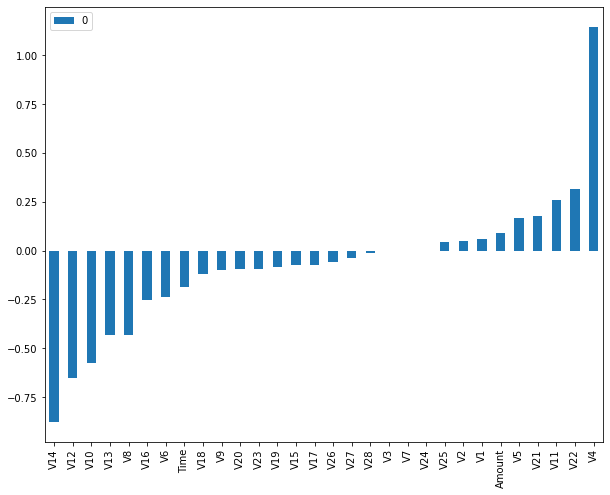

In [207]:
lr_coefs.plot.bar(figsize=(10,8))

**Задание**: составьте список самых важных фичей по версии логистической регрессии features_list_lr

In [245]:
features_list_lr = ['V14', 'V4', 'V12', 'V10', 'V13', 'V8']

### Отбор случайным лесом

Поиск наилучшего разбиения:
$$ Q(X_m, j, t) = H(X_m) - \frac{|X_l|}{|X_m|}H(X_l) - \frac{|X_r|}{|X_m|}H(X_r) \rightarrow \max_{j,t}$$

$H(X)$ - критерий информативности

Для *решающего дерева*:
- Чем сильнее уменьшили $𝐻(𝑋)$, тем лучше признак
- Важность признака $𝑅_𝑗$: просуммируем уменьшения по всем вершинам, где разбиение делалось по признаку 𝑗

Для *случайного леса*:

- Сумма важностей $𝑅_𝑗$ по всем деревьям
- Чем больше, тем важнее признак
- Учитывается важность признаков в совокупности

**Задание**: Обучим случайный лес

In [230]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=5)

In [231]:
rf_coefs = pd.DataFrame(rf.feature_importances_, index=features).sort_values(0)
rf_coefs

,0
V24,0.000705
V15,0.000882
V13,0.001060
V20,0.001201
Time,0.001294
V26,0.001300
V22,0.001360
V23,0.001425
Amount,0.001830
V27,0.002014


**Задание**: визуализируйте важность признаков в виде столбцовой диаграммы

<AxesSubplot:>

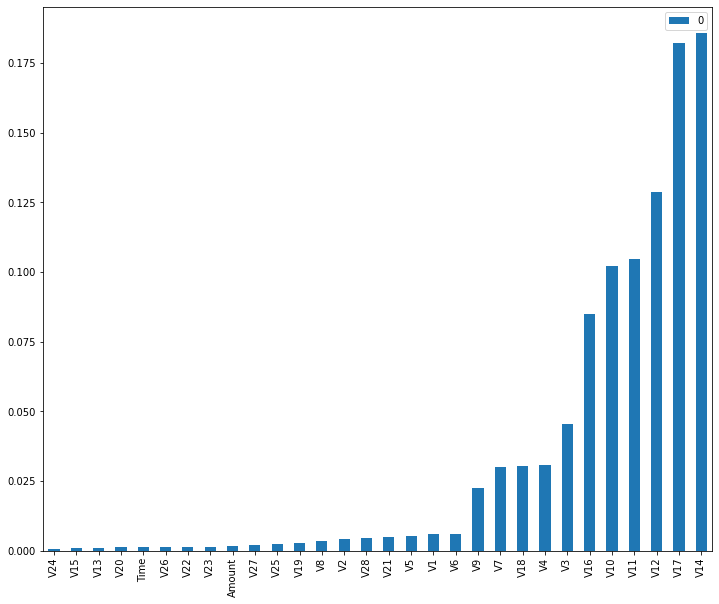

In [232]:
rf_coefs.plot.bar(figsize=(12,10))

**Задание**: составьте список самых важных фичей по версии случайного леса features_list_rf

## 5. Будем учить на разных группах признаков

**Задание**: давайте соберем функцию для обучения. Подадим ей:
- model
- X_train
- X_test
- y_train
- y_test
- features: набор признаков для обучения
<br> 
В ответ она нам вернет: модель и значение roc_auc

In [291]:
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix

def train(model, X_train, X_test, y_train, y_test, features):
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features]), columns=features)
    X_test_scaled =  pd.DataFrame(scaler.transform(X_test[features]), columns=features)
    
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    print('Train:', classification_report(y_train, y_pred_train))
    print('Test:', classification_report(y_test, y_pred_test))
    
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
    auc_precision_recall_train = auc(recall, precision)
    print(f'Train ROC AUC: {roc_auc_score(y_train, y_pred_train):.2}, PR AUC: {auc_precision_recall_train:.2}')
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
    auc_precision_recall_test = auc(recall, precision)
    print(f'Test ROC AUC: {roc_auc_score(y_test, y_pred_test):.2}, PR AUC: {auc_precision_recall_test:.2}')

    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
    
    return auc_precision_recall_test


**Задание**: Примените функцию, обучите логистическую регрессию на самых важных признаках

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21324
           1       0.94      0.76      0.84       369

    accuracy                           1.00     21693
   macro avg       0.97      0.88      0.92     21693
weighted avg       0.99      1.00      0.99     21693

Test:               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7108
           1       0.91      0.70      0.79       123

    accuracy                           0.99      7231
   macro avg       0.95      0.85      0.89      7231
weighted avg       0.99      0.99      0.99      7231

Train ROC AUC: 0.88, PR AUC: 0.85
Test ROC AUC: 0.85, PR AUC: 0.8


0.8047835038686368

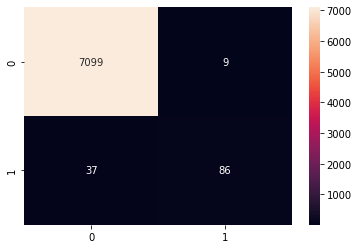

In [292]:
lr = LogisticRegression(penalty='l2',solver='liblinear')

train(lr, X_train, X_test, y_train, y_test, features_list_tscore[:3])


Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21324
           1       0.97      0.77      0.85       369

    accuracy                           1.00     21693
   macro avg       0.98      0.88      0.93     21693
weighted avg       1.00      1.00      1.00     21693

Test:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7108
           1       0.98      0.72      0.83       123

    accuracy                           1.00      7231
   macro avg       0.99      0.86      0.91      7231
weighted avg       0.99      1.00      0.99      7231

Train ROC AUC: 0.88, PR AUC: 0.87
Test ROC AUC: 0.86, PR AUC: 0.85


0.8531505956953979

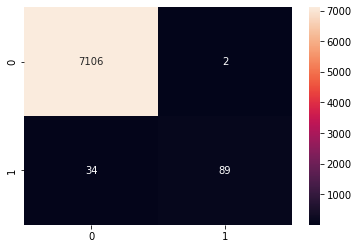

In [293]:

lr = LogisticRegression(penalty='l2',solver='liblinear')

train(lr, X_train, X_test, y_train, y_test, features_corr)


**Задание**: Примените функцию, обучите случайный лес на самых важных признаках

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21324
           1       0.98      0.81      0.89       369

    accuracy                           1.00     21693
   macro avg       0.99      0.90      0.94     21693
weighted avg       1.00      1.00      1.00     21693

Test:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7108
           1       0.97      0.79      0.87       123

    accuracy                           1.00      7231
   macro avg       0.98      0.89      0.93      7231
weighted avg       1.00      1.00      1.00      7231

Train ROC AUC: 0.9, PR AUC: 0.9
Test ROC AUC: 0.89, PR AUC: 0.88


0.8811067580527832

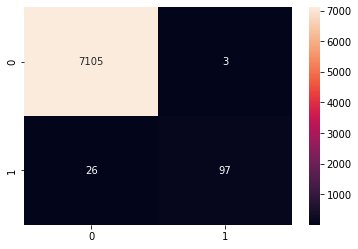

In [294]:
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
train(rf, X_train, X_test, y_train, y_test, features_corr)

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21324
           1       0.98      0.83      0.90       369

    accuracy                           1.00     21693
   macro avg       0.99      0.92      0.95     21693
weighted avg       1.00      1.00      1.00     21693

Test:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7108
           1       0.98      0.80      0.88       123

    accuracy                           1.00      7231
   macro avg       0.99      0.90      0.94      7231
weighted avg       1.00      1.00      1.00      7231

Train ROC AUC: 0.92, PR AUC: 0.91
Test ROC AUC: 0.9, PR AUC: 0.89


0.89010265197383

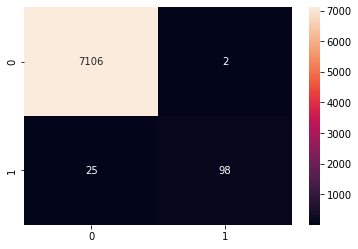

In [297]:
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
train(rf, X_train, X_test, y_train, y_test, features_list_tscore[:5])

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21324
           1       0.98      0.83      0.90       369

    accuracy                           1.00     21693
   macro avg       0.99      0.92      0.95     21693
weighted avg       1.00      1.00      1.00     21693

Test:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7108
           1       0.98      0.80      0.88       123

    accuracy                           1.00      7231
   macro avg       0.99      0.90      0.94      7231
weighted avg       1.00      1.00      1.00      7231

Train ROC AUC: 0.92, PR AUC: 0.91
Test ROC AUC: 0.9, PR AUC: 0.89


0.89010265197383

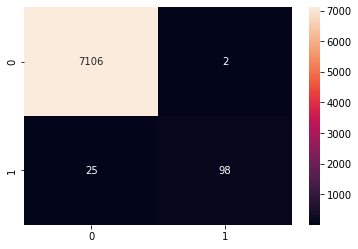

In [296]:
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
train(rf, X_train, X_test, y_train, y_test, features_list_lr )
